# Face Tracking and Object Localization Project

## Project Overview

This computer vision and machine learning project aims to develop a system for face tracking and object localization using deep learning techniques. The project involves the creation of a custom model, data preparation, and training to achieve accurate face tracking and localization.

## Project Components

### 1. Data Preparation

- **Data Collection**: Collect a dataset of images that contain faces and corresponding bounding box annotations.

- **Data Augmentation**: Apply data augmentation techniques to increase the diversity of the dataset and improve model generalization.

### 2. Model Architecture

- **Feature Extraction**: Utilize a pre-trained VGG16 model to extract features from input images. These features will be used for both classification and localization tasks.

- **Classification Branch**: Design a classification branch to identify whether an image contains a face or a specific object of interest.

- **Localization Branch**: Create a localization branch to predict the coordinates of bounding boxes around detected objects.

### 3. Custom Loss Functions

- **Classification Loss**: Implement binary cross-entropy loss for the classification branch to measure the dissimilarity between predicted class labels and ground truth.

- **Localization Loss**: Develop a custom localization loss function to assess the accuracy of predicted bounding box coordinates with respect to the actual bounding boxes.

### 4. Model Training

- **FaceTracker Model**: Define a custom `FaceTracker` model that combines both classification and localization branches. This model will be used for training and evaluation.

- **Batch Processing**: Train and evaluate the model using batches of input images and labels. Implement forward passes, loss calculations, and gradient updates during training.

### 5. Model Evaluation

- Assess the model's performance through testing and validation.

- Evaluate classification accuracy and localization precision.

## Project Goals

The primary goals of this project are as follows:

- Develop a robust face tracking and object localization system using deep learning.

- Achieve accurate object detection and localization on a diverse dataset.

- Improve the model's classification and localization capabilities through custom loss functions and model architecture.

- Prepare the model for real-time applications and deployment.

In [ ]:
# Install the dependencies
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### Data Collection

In [1]:
# Import the necessary libraries
import os
import time
import uuid
import cv2

In [2]:
# Create the path for the images.
IMAGES_PATH = os.path.join('data','images')

# Set how many images the camera will take.
number_images = 90

In [4]:
# Create a video capture object for the default camera (my cameras index is at 0)
cap = cv2.VideoCapture(0)

# Loop to capture a specified number of images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    
    # Capture a frame from the camera
    ret, frame = cap.read()
    
    # Generate a unique image filename using a UUID and store it in the 'IMAGES_PATH' directory
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    
    # Save the captured frame as an image with the generated filename
    cv2.imwrite(imgname, frame)
    
    # Display the captured frame in a window named 'frame'
    cv2.imshow('frame', frame)
    
    # Add a 0.5-second delay to control the capture rate
    time.sleep(0.5)

    # Check for the 'q' key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera capture object
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()

## Label the objects in the images

In [5]:
!labelme
# If you get the error below try typing in the command prompt "python -m labelme"

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\halro\.labelmerc


### Data preprocessing

In [6]:
# Import the necessary libraries
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
# List the available physical GPU devices using TensorFlow
gpu_devices = tf.config.list_physical_devices('GPU')

[]

In [9]:
# Create a TensorFlow data pipeline for a list of image files matching the specified pattern
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [10]:
# Make sure an image comes from this or the path is incorrect
images.as_numpy_iterator().next()

b'data\\images\\1efc50b2-7841-11ee-9992-14d42460a87a.jpg'

In [11]:
# Create a function to load the images
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
# Map the images
images = images.map(load_image)

In [13]:
# Display the images vectors
images.as_numpy_iterator().next()

array([[[135, 140, 146],
        [134, 139, 145],
        [134, 137, 144],
        ...,
        [ 84,  75,  58],
        [ 84,  77,  59],
        [ 85,  78,  60]],

       [[133, 138, 142],
        [133, 138, 142],
        [134, 137, 142],
        ...,
        [ 84,  77,  59],
        [ 85,  78,  60],
        [ 86,  79,  61]],

       [[130, 134, 137],
        [131, 135, 138],
        [134, 135, 139],
        ...,
        [ 85,  78,  60],
        [ 85,  78,  62],
        [ 85,  79,  63]],

       ...,

       [[ 83,  74,  41],
        [ 83,  75,  39],
        [ 81,  75,  39],
        ...,
        [ 68,  57,  29],
        [ 71,  57,  30],
        [ 71,  57,  30]],

       [[ 81,  75,  43],
        [ 81,  75,  43],
        [ 81,  75,  43],
        ...,
        [ 67,  55,  29],
        [ 70,  56,  30],
        [ 70,  56,  30]],

       [[ 81,  74,  45],
        [ 81,  74,  45],
        [ 81,  75,  43],
        ...,
        [ 69,  57,  31],
        [ 71,  56,  33],
        [ 72,  57,  34]]

In [14]:
# Batch the images to display 4 images
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
# Define the images to be plotted
plot_images = image_generator.next()

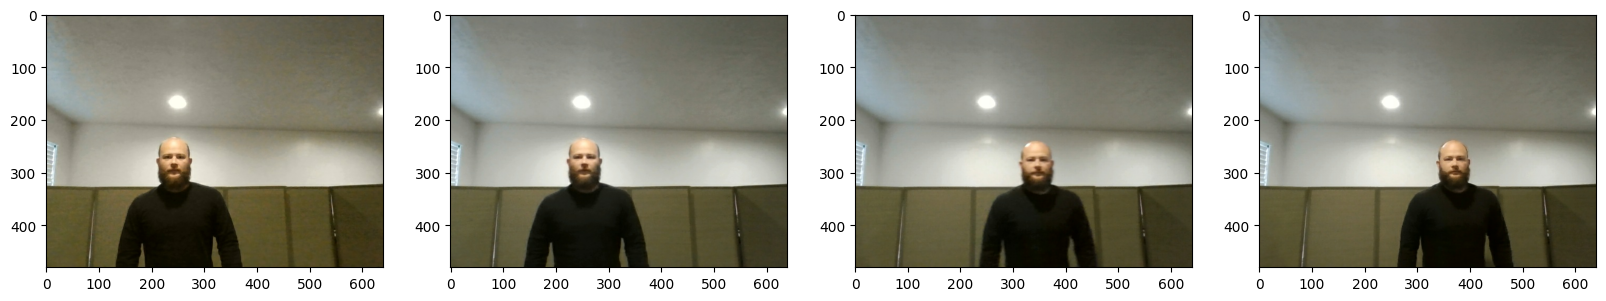

In [16]:
# Show the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

At this point I manually split the images by a 60% to train, 15% to test, 15% to validation.

In [24]:
# Match the json files with their corresponding images
for folder in ['train', 'test', 'val']:
    # Iterate through the files in the 'images' directory of each folder
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        # Extract the filename without the file extension and add a '.json' extension
        filename = file.split('.')[0] + '.json'
        
        # Create the full path to the corresponding JSON label file in the 'labels' directory
        existing_filepath = os.path.join('data', 'labels', filename)
        
        # Check if the JSON label file already exists
        if os.path.exists(existing_filepath):
            # If it exists, create a new path in the corresponding folder
            new_filepath = os.path.join('data', folder, 'labels', filename)
            
            # Replace the existing JSON label file with the new one in the appropriate folder
            os.replace(existing_filepath, new_filepath)

### Data augmentation

First we will test it on 1 image and then build a pipeline for the rest of the images

In [25]:
# Import the necessary libraries
import albumentations as alb

In [26]:
# Define the augmentor
augmentor = alb.Compose([
    # Randomly crop the image to a size of 450x450 pixels
    alb.RandomCrop(width=450, height=450),
    
    # Apply horizontal flipping with a 50% probability
    alb.HorizontalFlip(p=0.5),
    
    # Apply random brightness and contrast adjustments with a 20% probability
    alb.RandomBrightnessContrast(p=0.2),
    
    # Apply random gamma adjustments with a 20% probability
    alb.RandomGamma(p=0.2),
    
    # Apply random RGB color shifts with a 20% probability
    alb.RGBShift(p=0.2),
    
    # Apply vertical flipping with a 50% probability
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


In [27]:
# Construct the path to the image file you want to read. Make sure to update this file or you will get an error
img = cv2.imread(os.path.join('data','train', 'images','1f4bdb8b-7841-11ee-84b0-14d42460a87a.jpg'))

In [28]:
# Load the image
with open(os.path.join('data', 'train', 'labels', '1f4bdb8b-7841-11ee-84b0-14d42460a87a.json'), 'r') as f:
    label = json.load(f)

In [29]:
# Display the coordinates of the bounding box
label['shapes'][0]['points']

[[219.468085106383, 234.14893617021278],
 [292.87234042553195, 337.87234042553195]]

In [30]:
# Get the shapes of the coordinates
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [31]:
# Display the coordinates
coords

[219.468085106383, 234.14893617021278, 292.87234042553195, 337.87234042553195]

In [33]:
from PIL import Image 
  
# get image 
filepath = "data/train/images/1f4bdb8b-7841-11ee-84b0-14d42460a87a.jpg"
img_size = Image.open(filepath) 
  
# get width and height 
width = img_size.width 
height = img_size.height 
  
# display width and height 
print("The height of the image is: ", height) 
print("The width of the image is: ", width) 

The height of the image is:  480
The width of the image is:  640


In [34]:
# Divide the coords
coords = list(np.divide(coords, [640,480,640,480]))

In [35]:
coords

[0.3429188829787234,
 0.48781028368794327,
 0.45761303191489366,
 0.7039007092198583]

In [36]:
# Augment the photo
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [37]:
# Display the augmented coords
augmented['bboxes']

[(0.3565957446808511,
  0.2625059101654845,
  0.5197163120567376,
  0.4930023640661938)]

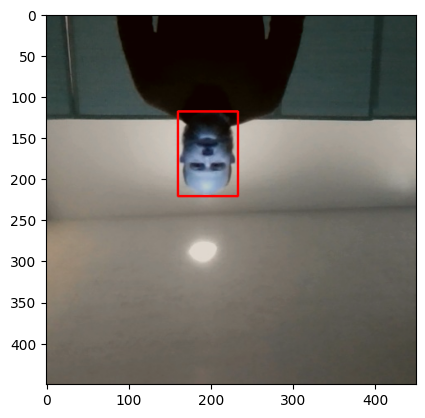

In [38]:
# Display the augmented photo. Ignore the blueness, I'm not sure why it comes out blue but the actual photo is normal.
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Now that it worked on 1 image we will build the pipeline for the rest of the images

In [39]:
# Iterate through the partitions: 'train', 'test', and 'val'
for partition in ['train', 'test', 'val']:
    # Iterate through the image files in the 'images' directory of each partition
    for image in os.listdir(os.path.join('data', partition, 'images')):
        
        # Read the image file
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        # Initialize default coordinates for a bounding box
        coords = [0, 0, 0.00001, 0.00001]
        
        # Create the file path for the JSON label file
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        
        # Check if the JSON label file exists
        if os.path.exists(label_path):
            # If it exists, load the label information from the JSON file
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            # Extract the bounding box coordinates from the loaded label data
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            
            # Scale the coordinates to match the image dimensions and create a list
            coords = list(np.divide(coords, [640, 480, 640, 480]))
        
        try:
            # Apply augmentation to the image and its associated bounding box
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                # Save the augmented image to a new file
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                # Create a dictionary to store annotation information
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                
                # Save the annotation as a JSON file
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        
        except Exception as e:
            # Handle exceptions if they occur during augmentation
            print(e)

In [40]:
# Create a TensorFlow dataset for a list of image files matching the specified pattern
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)

# Apply a function 'load_image' to load and preprocess the image files
train_images = train_images.map(load_image)

# Resize all images in the dataset to a common size (e.g., 120x120 pixels)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))

# Normalize pixel values of the images to the range [0, 1] (assuming 0-255 range input)
train_images = train_images.map(lambda x: x / 255)

In [41]:
# Create a TensorFlow dataset for a list of test image files matching the specified pattern
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)

# Apply a function 'load_image' to load and preprocess the test image files
test_images = test_images.map(load_image)

# Resize all test images in the dataset to a common size (e.g., 120x120 pixels)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120))

# Normalize pixel values of the test images to the range [0, 1] (assuming 0-255 range input)
test_images = test_images.map(lambda x: x / 255)

In [42]:
# Create a TensorFlow dataset for a list of validation (val) image files matching the specified pattern
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)

# Apply a function 'load_image' to load and preprocess the validation (val) image files
val_images = val_images.map(load_image)

# Resize all validation (val) images in the dataset to a common size (e.g., 120x120 pixels)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120))

# Normalize pixel values of the validation (val) images to the range [0, 1] (assuming 0-255 range input)
val_images = val_images.map(lambda x: x / 255)

In [43]:
# Display the vector on the train image
train_images.as_numpy_iterator().next()

array([[[0.34356618, 0.32395834, 0.24552695],
        [0.35      , 0.33039215, 0.25196078],
        [0.34528187, 0.32567403, 0.24969363],
        ...,
        [0.48284313, 0.46715686, 0.42009804],
        [0.48382354, 0.46813726, 0.42107844],
        [0.48621324, 0.47052696, 0.42346814]],

       [[0.3463848 , 0.32677695, 0.24883579],
        [0.34558824, 0.3259804 , 0.24803922],
        [0.3528799 , 0.33327207, 0.25484067],
        ...,
        [0.48927698, 0.47359067, 0.42653185],
        [0.48235294, 0.46666667, 0.41960785],
        [0.49362746, 0.4779412 , 0.43088236]],

       [[0.3521446 , 0.3286152 , 0.27371323],
        [0.35637254, 0.33284312, 0.27610293],
        [0.3602941 , 0.33719364, 0.27316177],
        ...,
        [0.49025735, 0.47457108, 0.42751226],
        [0.4833946 , 0.46770832, 0.4206495 ],
        [0.47549018, 0.4598039 , 0.4127451 ]],

       ...,

       [[0.27941176, 0.22843137, 0.09509804],
        [0.26574755, 0.21476716, 0.08241422],
        [0.22199754, 0

In [44]:
# Create a function to load the labels
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [45]:
# Load labels to tensorflow dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
# Load labels to tensorflow dataset
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
# Load labels to tensorflow dataset
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [48]:
# Show the lobels vector
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.628 , 0.4966, 0.8066, 0.7305], dtype=float16))

In [49]:
# Create a joint dataset by zipping (combining) the training images and labels
train = tf.data.Dataset.zip((train_images, train_labels))
# Shuffle the combined dataset to introduce randomness during training
train = train.shuffle(5000)
# Create batches of data for training, with each batch containing 8 samples
train = train.batch(8)
# Use prefetch to improve data pipeline performance by overlapping data loading and model training
train = train.prefetch(4)

In [50]:
# Create a joint dataset by zipping (combining) the training images and labels
test = tf.data.Dataset.zip((test_images, test_labels))
# Shuffle the combined dataset to introduce randomness during training
test = test.shuffle(1300)
# Create batches of data for training, with each batch containing 8 samples
test = test.batch(8)
# Use prefetch to improve data pipeline performance by overlapping data loading and model training
test = test.prefetch(4)

In [51]:
# Create a joint dataset by zipping (combining) the training images and labels
val = tf.data.Dataset.zip((val_images, val_labels))
# Shuffle the combined dataset to introduce randomness during training
val = val.shuffle(1000)
# Create batches of data for training, with each batch containing 8 samples
val = val.batch(8)
# Use prefetch to improve data pipeline performance by overlapping data loading and model training
val = val.prefetch(4)

In [52]:
# Show the shape
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [56]:
data_samples = train.as_numpy_iterator()

In [57]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


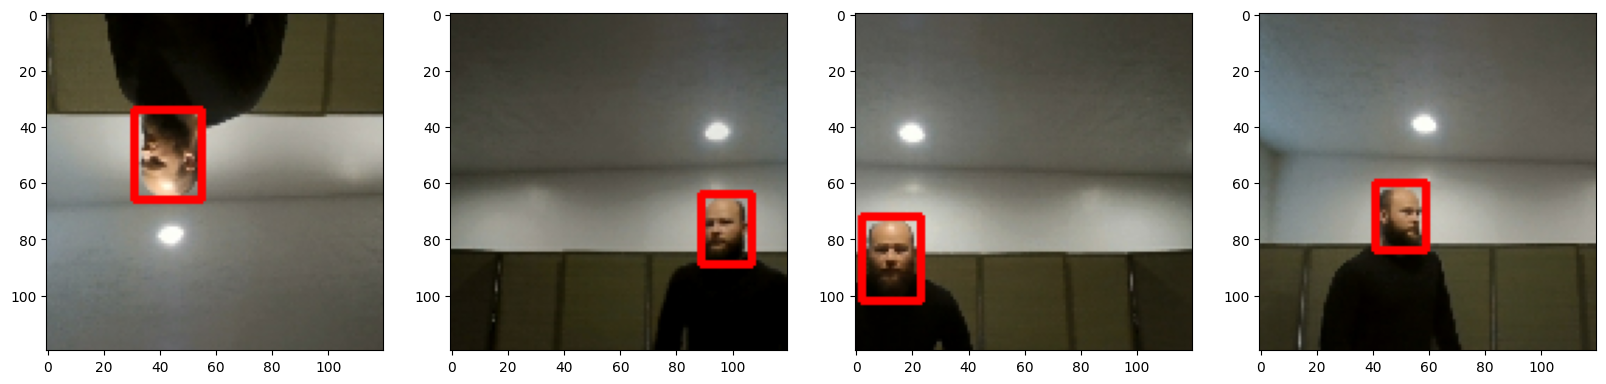

In [58]:
# Show the augmented images with the coordinates
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Great our data pipeline worked and all the photos have been augmented and their bounding boxes are in the correct location.

### Building the model

We are going to be using the VGG16 model to help us build our own custom model.

In [59]:
# Import the necessary libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [60]:
# Load the VGG16 model
vgg = VGG16(include_top=False)

In [61]:
# Show the summary of the VGG16
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [62]:
# Define a function to build a custom model
def build_model():
    # Create an input layer with a shape of (120, 120, 3) for the image data
    input_layer = Input(shape=(120, 120, 3))
    
    # Use a pre-trained VGG16 model as a feature extractor (excluding the top layer)
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    # Apply global max pooling to the VGG features
    f1 = GlobalMaxPooling2D()(vgg)
    # Add a dense layer with 2048 units and ReLU activation for classification
    class1 = Dense(2048, activation='relu')(f1)
    # Add an output layer with a single neuron and sigmoid activation for binary classification
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding Box Model
    # Apply global max pooling to the VGG features (shared feature extraction)
    f2 = GlobalMaxPooling2D()(vgg)
    # Add a dense layer with 2048 units and ReLU activation for bounding box regression
    regress1 = Dense(2048, activation='relu')(f2)
    # Add an output layer with 4 neurons and sigmoid activation for bounding box coordinates
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    # Create a composite model with the input and both classification and regression outputs
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return facetracker

In [63]:
# Build the model
facetracker = build_model()

In [64]:
# Show the summary of our new model
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [65]:
X, y = train.as_numpy_iterator().next()

In [66]:
# Display the shape
X.shape

(8, 120, 120, 3)

In [67]:
# Use the model to predict
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 447ms/step


In [68]:
# Display predictions
classes, coords

(array([[0.48062912],
        [0.44112167],
        [0.44176486],
        [0.4596968 ],
        [0.46359366],
        [0.4556895 ],
        [0.45869175],
        [0.4487481 ]], dtype=float32),
 array([[0.1971245 , 0.5896856 , 0.5080546 , 0.41364488],
        [0.2634261 , 0.5624481 , 0.50708425, 0.37790945],
        [0.29021877, 0.564944  , 0.5288395 , 0.402451  ],
        [0.22786564, 0.5618185 , 0.36836475, 0.32434094],
        [0.23219743, 0.6025496 , 0.47170267, 0.42125782],
        [0.30252445, 0.5769484 , 0.51513994, 0.38262647],
        [0.3062366 , 0.54016685, 0.55376583, 0.3971869 ],
        [0.26496014, 0.5280989 , 0.5511645 , 0.4276511 ]], dtype=float32))

In [69]:
# Calculate the total number of batches in the training dataset
batches_per_epoch = len(train)
# Calculate the learning rate decay factor based on a decay formula
lr_decay = (1./0.75 -1)/batches_per_epoch

In [70]:
# Add the Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [71]:
# Define a custom loss function for object localization
def localization_loss(y_true, yhat):
    # Calculate the squared difference between the true and predicted x and y coordinates
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))
    
    # Calculate the height and width of the true bounding box
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    # Calculate the height and width of the predicted bounding box
    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]
    
    # Calculate the squared difference between the true and predicted bounding box sizes
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    # Return the sum of the squared coordinate difference and squared size difference as the loss
    return delta_coord + delta_size

In [72]:
# Use binary cross-entropy loss function for classification tasks
classloss = tf.keras.losses.BinaryCrossentropy()

# Define the custom localization loss function for regression tasks
regressloss = localization_loss

In [73]:
# Calculate the localization loss between the true bounding box coordinates (y[1]) and the predicted coordinates (coords)
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.904604>

In [74]:
# Calculate the classification loss between the true class labels (y[0]) and the predicted class scores (classes)
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.78507733>

In [75]:
# Calculate the regression loss (localization loss) between the true bounding box coordinates (y[1]) and the predicted coordinates (coords)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.904604>

In [76]:
# Define a custom Model called FaceTracker
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    # Compile method for configuring the model
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss  # Classification loss function
        self.lloss = localizationloss  # Localization loss function
        self.opt = opt  # Optimizer for model training

    # Training step for the model
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            # Calculate classification and localization losses
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            # Calculate the total loss as a combination of localization and classification losses
            total_loss = batch_localizationloss + 0.5 * batch_classloss

            # Compute gradients for model training
            grad = tape.gradient(total_loss, self.model.trainable_variables)

        # Apply gradients using the optimizer
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    # Test step for the model
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        # Calculate classification and localization losses
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

        # Calculate the total loss as a combination of localization and classification losses
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    # Call method for forward pass
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


### Training the model

In [77]:
# Set the model as a variable
model = FaceTracker(facetracker)

In [78]:
# Compile the model
model.compile(opt, classloss, regressloss)

In [79]:
# Create the logs directory
logdir='logs'

In [80]:
# This will create a folder in the directory to store the logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
# Train the model
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
450/450 [==============================] - 653s 1s/step - total_loss: 0.1830 - class_loss: 0.0490 - regress_loss: 0.1585 - val_total_loss: 0.0207 - val_class_loss: 1.5915e-04 - val_regress_loss: 0.0206
Epoch 2/10
450/450 [==============================] - 668s 1s/step - total_loss: 0.0708 - class_loss: 0.0198 - regress_loss: 0.0609 - val_total_loss: 0.0025 - val_class_loss: 8.8341e-05 - val_regress_loss: 0.0025
Epoch 3/10
450/450 [==============================] - 809s 2s/step - total_loss: 0.0497 - class_loss: 0.0143 - regress_loss: 0.0425 - val_total_loss: 0.0077 - val_class_loss: 1.0326e-04 - val_regress_loss: 0.0076
Epoch 4/10
450/450 [==============================] - 809s 2s/step - total_loss: 0.0394 - class_loss: 0.0125 - regress_loss: 0.0331 - val_total_loss: 0.0176 - val_class_loss: 4.7730e-05 - val_regress_loss: 0.0176
Epoch 5/10
450/450 [==============================] - 897s 2s/step - total_loss: 0.0358 - class_loss: 0.0106 - regress_loss: 0.0305 - val_total_loss

In [82]:
# Show the models history of performance during training
hist.history

{'total_loss': [0.023213321343064308,
  0.005140946712344885,
  0.01221571583300829,
  0.0074857426807284355,
  0.004439851734787226,
  0.008434558287262917,
  0.006190241314470768,
  0.010820167139172554,
  0.004020007327198982,
  0.00509507954120636],
 'class_loss': [0.00022674814681522548,
  0.00013499629858415574,
  0.0001514870673418045,
  0.00014438966172747314,
  6.88792351866141e-05,
  0.00010282096627634019,
  1.7151562133221887e-05,
  0.0001621170376893133,
  1.896209505503066e-05,
  0.0003257440112065524],
 'regress_loss': [0.023099947720766068,
  0.005073448643088341,
  0.012139972299337387,
  0.0074135479517281055,
  0.004405411891639233,
  0.008383147418498993,
  0.006181665696203709,
  0.010739108547568321,
  0.004010526463389397,
  0.0049322075210511684],
 'val_total_loss': [0.02066103182733059,
  0.0025258976966142654,
  0.007696941494941711,
  0.017581205815076828,
  0.0012363294372335076,
  0.0075331139378249645,
  0.005325306206941605,
  0.007585196755826473,
  0.00

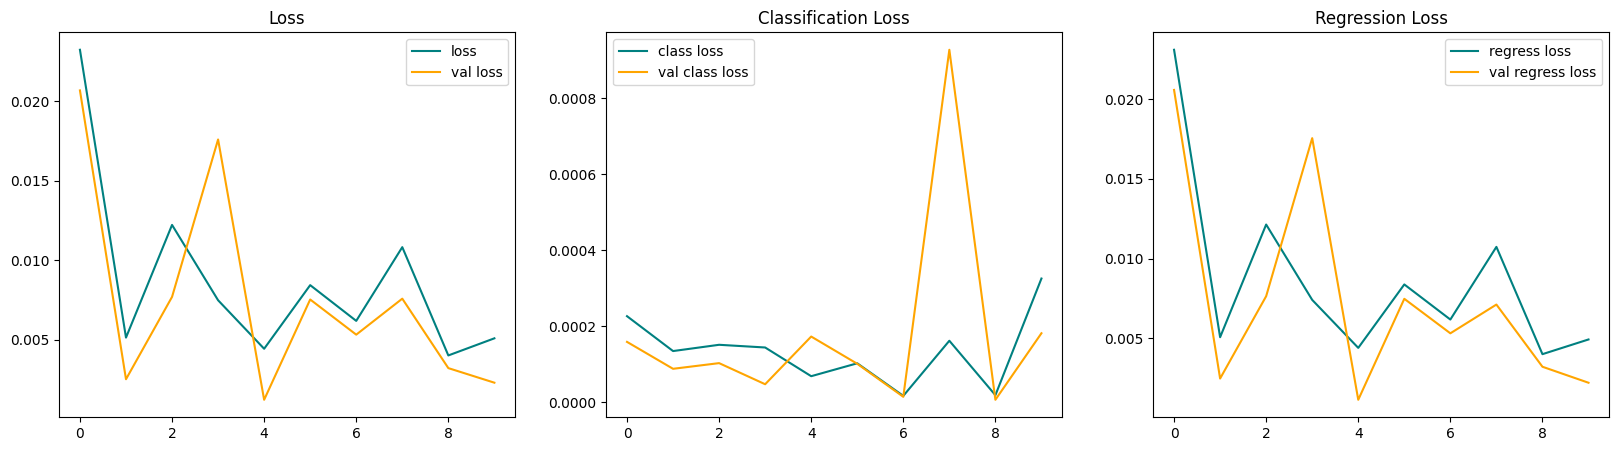

In [83]:
# Plot the models performance
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

I don't love these spikes in our results likely this would have flattened out had we put more than 10 epochs, however each epoch on my machine took about 12 mins to run so at 10 epochs it put me at 2 hours of run time. At the end of this notebook we do test the model and it performed decently well on my face with this performance so I didn't feel the need to train additionally. Feel free to add additional epochs and test it out if you have cloned this repo.

In [84]:
test_data = test.as_numpy_iterator()

In [85]:
test_sample = test_data.next()

In [86]:
# Predict on the test data using the model
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 448ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


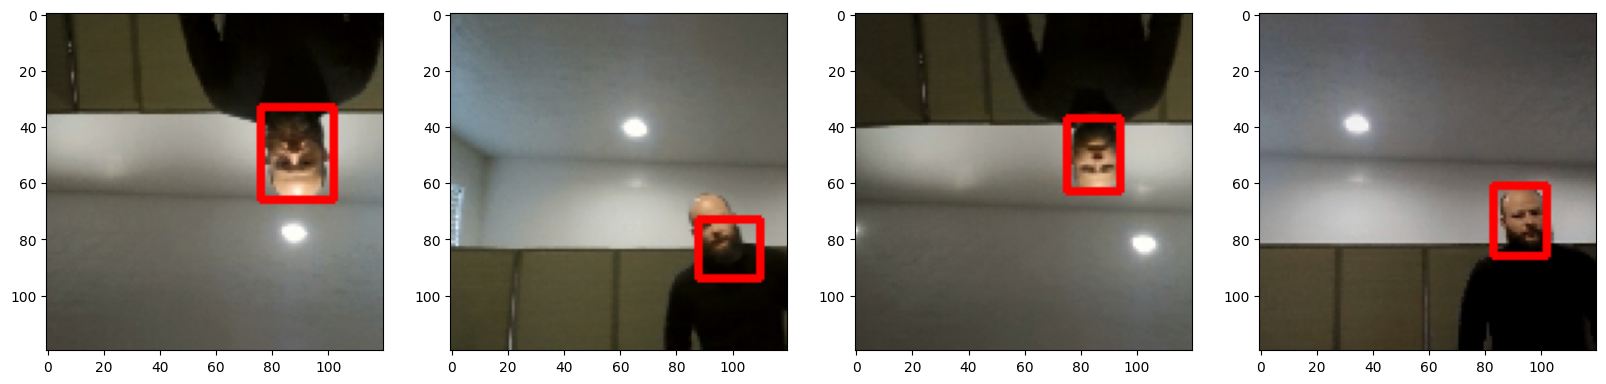

In [87]:
# Display the models predictions with bounding boxes on new data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

Here we can see that it mostly gets the face right. There is a little bit of an error. After testing live, some angles the model doesn't pick up the face exactly, the bounding box will sometimes get larger but the face is always within the bounding box. 

### Save the model and test

In [88]:
# Import the necessary libraries
from tensorflow.keras.models import load_model

In [89]:
# Save the model
facetracker.save('facetracker.keras')

In [90]:
# Load the model to test it
facetracker = load_model('facetracker.keras')

In [91]:
# Test the model on your camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 68ms/step


KeyboardInterrupt: 

### Conclusion

In conclusion, the model demonstrated good performance, but there are opportunities for improvement. One key enhancement would be to gather additional data, a common practice in machine learning, to further refine its capabilities.

The model excelled when I was facing the camera directly. However, its performance slightly declined when I turned my head or tilted it. While it still successfully detected my face, the precision of the bounding boxes was compromised in these scenarios.

It's important to note that the model was trained specifically on my facial features, which include less hair on my head and beard. If you were to use this exact model and your facial characteristics differ significantly from mine, the model's accuracy may be impacted. As a testament to this, when I had my wife try the model with the camera, we observed similar performance challenges when tilting her head or turning away. To create a model to be able to accurately read multiple faces it would be advised to use data containing multiple faces.

In summary, while the model exhibits promising capabilities, fine-tuning and broader data collection could enhance its versatility and robustness across a wider range of facial features and orientations.